# This notebook has some utilities to manage the already deployed cluster. 
- uninstall DYNAMOS
- trigger VFL
- ... 

## FABlib API References Examples

- [fablib.show_config](https://fabric-fablib.readthedocs.io/en/latest/fablib.html#fabrictestbed_extensions.fablib.fablib.FablibManager.show_config)
- [fablib.list_sites](https://fabric-fablib.readthedocs.io/en/latest/fablib.html#fabrictestbed_extensions.fablib.fablib.FablibManager.list_sites)
- [fablib.list_hosts](https://fabric-fablib.readthedocs.io/en/latest/fablib.html#fabrictestbed_extensions.fablib.fablib.FablibManager.list_hosts)
- [fablib.new_slice](https://fabric-fablib.readthedocs.io/en/latest/fablib.html#fabrictestbed_extensions.fablib.fablib.FablibManager.new_slice)
- [slice.add_node](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.add_node)
- [slice.submit](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.submit)
- [slice.get_nodes](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.get_nodes)
- [slice.list_nodes](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.list_nodesß)
- [slice.show](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.show)
- [node.execute](https://fabric-fablib.readthedocs.io/en/latest/node.html#fabrictestbed_extensions.fablib.node.Node.execute)
- [slice.delete](https://fabric-fablib.readthedocs.io/en/latest/slice.html#fabrictestbed_extensions.fablib.slice.Slice.delete) 

In [1]:
%%time
import datetime
import json
import asyncio

from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

fablib = fablib_manager()

fablib.show_config();

User: koufalex@gmail.com bastion key is valid!
Configuration is valid


Orchestrator,orchestrator.fabric-testbed.net
Credential Manager,cm.fabric-testbed.net
Core API,uis.fabric-testbed.net
Artifact Manager,artifacts.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,49f65ad7-d8a2-4ab9-8ca0-ba777a2e0ea2
Bastion Host,bastion.fabric-testbed.net
Bastion Username,koufalex_0000215529
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key


CPU times: user 1.91 s, sys: 248 ms, total: 2.16 s
Wall time: 4.33 s


In [2]:
slice = fablib.get_slice(name="DYNAMOS-on-FABRIC");
nodes = slice.get_nodes();
print(nodes)


[<fabrictestbed_extensions.fablib.node.Node object at 0x7fecfa2f7ad0>, <fabrictestbed_extensions.fablib.node.Node object at 0x7fecfa2e8d90>, <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd41a69d0>, <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd417b550>, <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd5b1e150>, <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd4185750>]


In [3]:
# Print ssh information
try:
    # Get slice nodes
    for node in slice.get_nodes():
        print(f"Node: {node.get_name()}")
        # Get the original SSH command
        original_ssh_command = node.get_ssh_command()
        # Print SSH commands to get into the nodes
        print(f"  SSH Command from FABRIC: {original_ssh_command}")
        # Replace the file paths in the SSH command
        updated_ssh_command = original_ssh_command.replace(
            "/home/fabric/work/fabric_config/slice_key", "~/.ssh_fabric/slice_key"
        ).replace(
            "/home/fabric/work/fabric_config/ssh_config", "ssh_config"
        )
        # Print the updated SSH command
        print(f"  SSH Command locally (ensuring it is saved according to below steps): {updated_ssh_command}")
    
except Exception as e:
    print(f"Fail: {e}")
    traceback.print_exc()

Node: control
  SSH Command from FABRIC: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe19:b747
  SSH Command locally (ensuring it is saved according to below steps): ssh -i ~/.ssh_fabric/slice_key -F ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe19:b747
Node: dynamos
  SSH Command from FABRIC: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fef2:4910
  SSH Command locally (ensuring it is saved according to below steps): ssh -i ~/.ssh_fabric/slice_key -F ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fef2:4910
Node: server
  SSH Command from FABRIC: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe63:3953
  SSH Command locally (ensuring it is saved according to below steps): ssh -i ~/.ssh_fabric/slice_key -F ssh_config ubuntu@2001:400

In [3]:
# get nodes and IPs 
def get_ip(node):
    interface = node.get_interface(network_name=f"Network-{node.get_site()}")
    return interface.get_ip_addr()

nodes_dict= dict()

for node in nodes[:]:
    ip = get_ip(node)
    name = node.get_name()
    nodes_dict[name] = {"ip": ip, "node": node}
    print(f"{name}: {ip}")

print(nodes_dict)

control: 10.137.8.2
dynamos: 10.137.8.3
server: 10.137.8.4
clientone: 10.137.8.5
clienttwo: 10.137.8.6
clientthree: 10.137.8.7
{'control': {'ip': '10.137.8.2', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecfa2f7ad0>}, 'dynamos': {'ip': '10.137.8.3', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecfa2e8d90>}, 'server': {'ip': '10.137.8.4', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd41a69d0>}, 'clientone': {'ip': '10.137.8.5', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd417b550>}, 'clienttwo': {'ip': '10.137.8.6', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd5b1e150>}, 'clientthree': {'ip': '10.137.8.7', 'node': <fabrictestbed_extensions.fablib.node.Node object at 0x7fecd4185750>}}


In [ ]:
# This is for resetting the kubespray cluster. 
# Use this if you are troubleshooting your Kubernetes cluster
# and you want to redeploy fresh.

# nodes_dict['control']['node'].upload_file(local_file_path="node_scripts/reset_kubespray.sh", remote_file_path="reset.sh");
# nodes_dict['control']['node'].execute(f"chmod +x reset.sh && ./reset.sh");

In [ ]:
# Add the relevant etcd data to the dynamos node (update etcd agreements etc)

# help(nodes_dict['dynamos']['node'])
# upload etcd files from filesystem instead of reading them from github
# nodes_dict['dynamos']['node'].upload_directory(local_directory_path="../configuration/etcd_launch_files", remote_directory_path="./")
# nodes_dict['dynamos']['node'].execute("ls etcd_launch_files")

# nodes_dict['dynamos']['node'].upload_file(local_file_path="node_scripts/define_etcd_data_local.sh", remote_file_path="define_etcd_data_local.sh");
# nodes_dict['dynamos']['node'].execute(f"chmod +x define_etcd_data_local.sh && ./define_etcd_data_local.sh");

In [54]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time


def plot_accuracy(rounds, accuracies, clients):
    clear_output(wait=True)
    # Plot accuracy over rounds, color by number of clients
    plt.figure(figsize=(10, 6))

    # Find transition points where number of clients changes
    # We'll split into segments with constant number of clients
    segments = []
    start_idx = 0
    for i in range(1, len(clients)):
        if clients[i] != clients[i - 1]:
            segments.append((start_idx, i, clients[i - 1]))
            start_idx = i
    segments.append((start_idx, len(clients), clients[-1]))

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    for idx, (start, end, n_clients) in enumerate(segments):
        plt.plot(rounds[start:end], accuracies[start:end], label=f"{n_clients} clients",
                 color=colors[idx % len(colors)])

    plt.xlabel('Training Round')
    plt.ylabel('r2 score')
    plt.title('VFL Training r2 score over training cycles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(bottom=-1)
    plt.show()
        # time.sleep(1)

In [52]:
# Upload the trigger script to the node 
nodes_dict['control']['node'].upload_file(local_file_path="node_scripts/trigger_VFL.sh", remote_file_path="trigger_VFL.sh")

<SFTPAttributes: [ size=1106 uid=1000 gid=1000 mode=0o100664 atime=1760606522 mtime=1760606961 ]>

In [19]:
%%time
# VFL TRIGGER 
# note: could make it so that ignores the output > null 

# res = nodes_dict['control']['node'].execute("bash trigger_VFL.sh")

 {"request_id":"89644c39-bfea-4faf-b775-eb408a57d013","status":"pending"} % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   550  100    72  100   478  22973   148k --:--:-- --:--:-- --:--:--  179k
CPU times: user 24.4 ms, sys: 7.19 ms, total: 31.6 ms
Wall time: 1.21 s


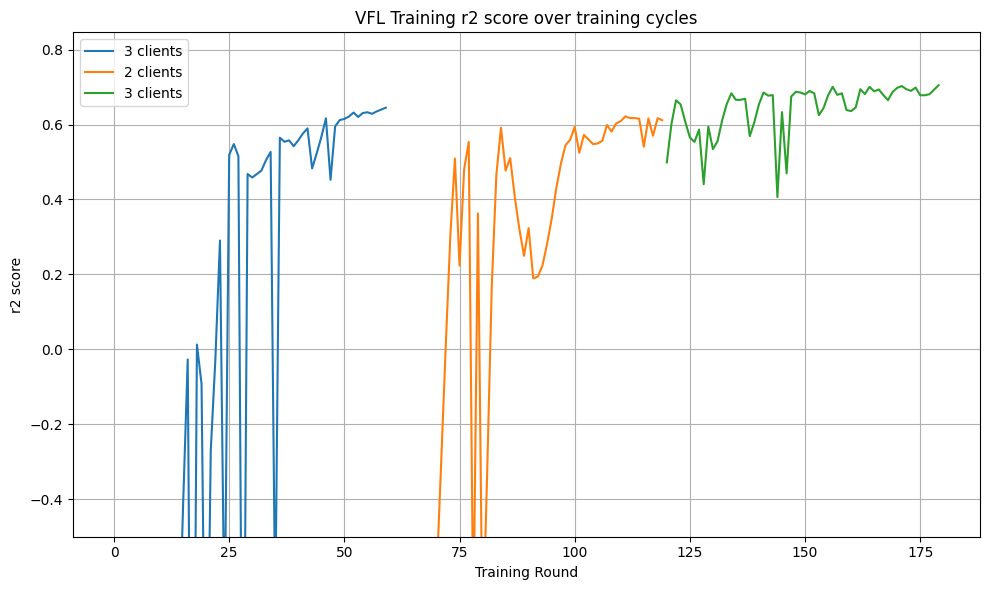

Finished with code: done


In [53]:
import json

res = nodes_dict['control']['node'].execute("bash trigger_VFL.sh")


# parse the request id from json 
res_dict = json.loads(res[0])
req_id = res_dict['request_id'] 
# req_status = res_dict['status']
print(req_id)
# print(req_status)
# print(type(res[1]))




start_time = time.time()
timeout = 180  # seconds 

while True:

    # upload the polling script
    nodes_dict['control']['node'].upload_file(local_file_path="node_scripts/poll_results.sh", remote_file_path="poll_results.sh")
    
    
    
    # POLL RESULTS 
    results = nodes_dict['control']['node'].execute(f"bash poll_results.sh {req_id}", quiet=True)
    
    results_dict = json.loads(results[0])
    # print(results_dict['metadata'])
    # print(results_dict['request_id'])
    # print(results_dict['status'])
    status = results_dict['status']
    # print(results_dict['results'])
    
    accuracies = [k["accuracy"] for k in results_dict['results']]
    clients = [k["clients"] for k in results_dict['results']]
    rounds = [k["train_round"] for k in results_dict['results']]

    if len(clients) <1:
        print("No results yet, waiting 2 seconds")
        time.sleep(2)
        continue
    
    plot_accuracy(rounds, accuracies, clients)
    if status!='pending': 
        break
    if time.time() - start_time > timeout:
        print(f"Process timed out. Start time: {start_time}, Duration{time.time() - start_time}, stopping...")
    time.sleep(2)

print("Finished with code: " + str(status))


In [33]:
accuracies = [k["accuracy"] for k in results_dict['results']]
clients = [k["clients"] for k in results_dict['results']]
rounds = [k["train_round"] for k in results_dict['results']]

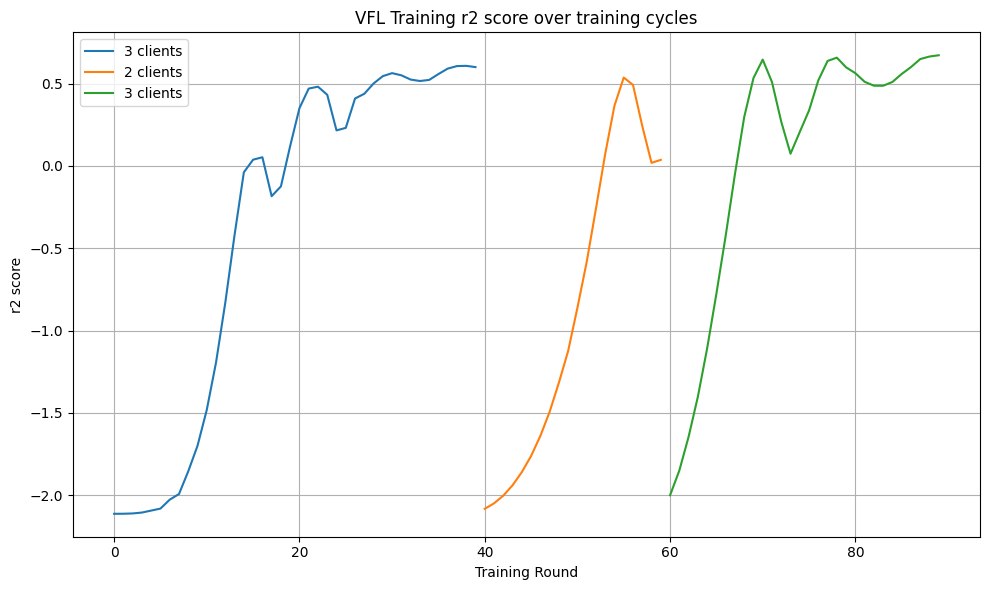

In [42]:
# for testing the incremental plotting
for lim1 in range(10, 100, 10):
    print(lim1)
    plot_accuracy(rounds[:lim1], accuracies[:lim1], clients[:lim1])
    time.sleep(1)

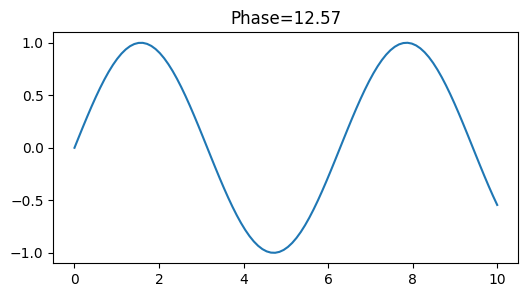

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time

x = np.linspace(0, 10, 100)

for phase in np.linspace(0, 4 * np.pi, 60):
    y = np.sin(x + phase)
    plt.figure(figsize=(6,3))
    plt.plot(x, y)
    plt.title(f"Phase={phase:.2f}")
    clear_output(wait=True)
    plt.show()
    time.sleep(0.2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0{
    "metadata": {
        "policy_reintroduction": 60,
        "policy_removal": 40,
        "total_rounds": 10,
        "training_backtrack": 0
    },
    "request_id": "41c8d594-a441-4ce0-b5bd-2714903e50a6",
    "results": [
        {
            "accuracy": -2.112539052963257,
            "clients": 3,
            "timestamp": "2025-10-15T14:29:23Z",
            "train_round": 0
        },
        {
            "accuracy": -2.1122469902038574,
            "clients": 3,
            "timestamp": "2025-10-15T14:29:23Z",
            "train_round": 1
        },
        {
            "accuracy": -2.11152982711792,
            "clients": 3,
            "timestamp": "2025-10-15T14:29:23Z",
            "train_round": 2
        },
        {
            "accur

In [82]:
%%time
# get API-GATEWAY logs 
nodes_dict['control']['node'].upload_file(local_file_path="../scripts/retrieve_logs.sh", remote_file_path="retrieve_logs.sh")
nodes_dict['control']['node'].execute(f"bash retrieve_logs.sh")

1.7605370374468927e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7605370374469671e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.7605370384475965e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7605370384476235e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.7605370394487271e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7605370394487512e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.7605370404499955e+09 DEBUG	/app/pkg/lib/go-grpc.go:51	returning conn GetGrpcConnection
1.7605370404501572e+09 DEBUG	/ap

('1.7605370374468927e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7605370374469671e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.7605370384475965e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7605370384476235e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.7605370394487271e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7605370394487512e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.7605370404499955e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go

In [41]:
%%time

nodes_dict['control']['node'].upload_file(local_file_path="../scripts/retrieve_logs_policy.sh", remote_file_path="retrieve_logs_policy.sh")
nodes_dict['control']['node'].execute(f"bash retrieve_logs_policy.sh")

1.7603621545040784e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7603621545041149e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.7603621555042522e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7603621555042899e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.760362156504626e+09 WARN	/app/pkg/lib/go-grpc.go:38	could not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"
1.7603621565046625e+09 DEBUG	/app/pkg/lib/go-grpc.go:44	Sleep 1 second
1.7603621575063543e+09 DEBUG	/app/pkg/lib/go-grpc.go:51	returning conn GetGrpcConnection
1.7603621575065098e+09 DEBUG	/app

('1.7603621545040784e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7603621545041149e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.7603621555042522e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7603621555042899e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.760362156504626e+09 \x1bWARN\x1b\t/app/pkg/lib/go-grpc.go:38\tcould not check: rpc error: code = Unavailable desc = connection error: desc = "transport: Error while dialing: dial tcp 127.0.0.1:50051: connect: connection refused"\n1.7603621565046625e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-grpc.go:44\tSleep 1 second\n1.7603621575063543e+09 \x1bDEBUG\x1b\t/app/pkg/lib/go-

In [66]:
%%time
# TODO: read the metrics based on the other script 

nodes_dict['control']['node'].upload_file(local_file_path="../scripts/retrieve_data.sh", remote_file_path="retrieve_data.sh")
nodes_dict['control']['node'].execute(f"bash retrieve_data.sh {2}")


-2.112530469894409
-2.11152982711792
-2.1070847511291504
-2.104970693588257
-2.076059341430664
-2.0829033851623535
-1.9754369258880615
-1.8747782707214355
-1.7195074558258057
-1.4995791912078857
-2.1020915508270264
-2.0844202041625977
-2.051020383834839
-1.9959380626678467
-1.9687869548797607
-2.059821844100952
-1.9815828800201416
-1.9706571102142334
-1.9120151996612549
-1.5650131702423096
-2.1125128269195557
-2.112224578857422
-2.1107711791992188
-2.1057560443878174
-2.105438709259033
-2.07344651222229
-2.0329020023345947
-1.9613666534423828
-1.8438167572021484
-1.6663122177124023
-1.4140856266021729
-1.0831735134124756
-0.6758177280426025
-0.27690041065216064
-0.9888384342193604
-0.03725409507751465
-0.1764448881149292
-0.12805688381195068
0.06951349973678589
0.2743264436721802
0.4248894453048706
0.487127423286438
-0.1479780673980713
-0.0705181360244751
0.4879170060157776
0.48925507068634033
0.4805227518081665
0.4916478395462036
-0.11230874061584473
0.45823103189468384
0.456557452678

('-2.112530469894409\n-2.11152982711792\n-2.1070847511291504\n-2.104970693588257\n-2.076059341430664\n-2.0829033851623535\n-1.9754369258880615\n-1.8747782707214355\n-1.7195074558258057\n-1.4995791912078857\n-2.1020915508270264\n-2.0844202041625977\n-2.051020383834839\n-1.9959380626678467\n-1.9687869548797607\n-2.059821844100952\n-1.9815828800201416\n-1.9706571102142334\n-1.9120151996612549\n-1.5650131702423096\n-2.1125128269195557\n-2.112224578857422\n-2.1107711791992188\n-2.1057560443878174\n-2.105438709259033\n-2.07344651222229\n-2.0329020023345947\n-1.9613666534423828\n-1.8438167572021484\n-1.6663122177124023\n-1.4140856266021729\n-1.0831735134124756\n-0.6758177280426025\n-0.27690041065216064\n-0.9888384342193604\n-0.03725409507751465\n-0.1764448881149292\n-0.12805688381195068\n0.06951349973678589\n0.2743264436721802\n0.4248894453048706\n0.487127423286438\n-0.1479780673980713\n-0.0705181360244751\n0.4879170060157776\n0.48925507068634033\n0.4805227518081665\n0.4916478395462036\n-0.11

In [12]:
for node in nodes:
    print(node)
    ssh_command = node.get_ssh_command().replace(
        "-i /home/fabric/work/fabric_config/slice_key", "-i ~/.ssh/keys/FABRIC-slice_key"
    ).replace(
        "-F /home/fabric/work/fabric_config/ssh_config ", ""
    )
    
    print(ssh_command);

-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
ID                 7e6ecd76-c04e-4227-9f31-3f4201a053ba
Name               control
Cores              2
RAM                8
Disk               100
Image              default_ubuntu_24
Image Type         qcow2
Host               losa-w3.fabric-testbed.net
Site               LOSA
Management IP      2001:400:a100:3070:f816:3eff:fe84:397d
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe84:397d
-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
ssh -i ~/.ssh/keys/FABRIC-slice_key ubuntu@2001:400:a100:3070:f816:3eff:fe84:397d
-----------------  -----------------------------------------

In [7]:
# Do we need to do it everytime?? I don;t think so but I should test 

slice = fablib.get_slice(name="DYNAMOS-on-FABRIC");
nodes = slice.get_nodes();

for node in nodes:
    ssh_command = node.get_ssh_command().replace(
        "-i /home/fabric/work/fabric_config/slice_key", "-i ~/.ssh/keys/FABRIC-slice_key"
    ).replace(
        "-F /home/fabric/work/fabric_config/ssh_config ", ""
    )
    
    print(ssh_command);

Uploading the node setup...


[<SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572167 mtime=1758572168 ]>,
 <SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572165 mtime=1758572165 ]>,
 <SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572165 mtime=1758572165 ]>,
 <SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572165 mtime=1758572165 ]>,
 <SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572165 mtime=1758572165 ]>,
 <SFTPAttributes: [ size=1222 uid=1000 gid=1000 mode=0o100664 atime=1758572167 mtime=1758572168 ]>]

In [23]:

# Configure DYNAMOS for the FABRIC nodes
# agents_string = ",".join(agents)
# thirdparties_string = ",".join(thirdparties)


# nodes_dict['control']['node'].upload_file(local_file_path="node_scripts/configure_dynamos.sh", remote_file_path="configure_dynamos.sh");
# nodes_dict['control']['node'].execute(f"chmod +x configure_dynamos.sh && ./configure_dynamos.sh {agents_string} {thirdparties_string}");

Adding agents...
- agent 'server'
- agent 'clientone'
- agent 'clienttwo'
- agent 'clientthree'

Adding third parties...


In [24]:
# Optionally override the installation scripts 
# nodes_dict['control']['node'].upload_file(local_file_path="../configuration/dynamos-configuration.sh", remote_file_path="/home/ubuntu/DYNAMOS/configuration/dynamos-configuration.sh")
# nodes_dict['control']['node'].upload_file(local_file_path="../configuration/fill-rabbit-pvc.sh", remote_file_path="/home/ubuntu/DYNAMOS/configuration/fill-rabbit-pvc.sh");


In [70]:
# install DYNAMOS
nodes_dict['control']['node'].execute(f"~/DYNAMOS/configuration/dynamos-configuration.sh")

DYNAMOS configuration v0.1.2
Setting up paths...
definitions_example.json copied over definitions.json to ensure a clean file
Generating RabbitMQ password...
Replacing tokens...
Installing namespaces...
Release "namespaces" does not exist. Installing it now.
NAME: namespaces
LAST DEPLOYED: Wed Oct 15 14:02:32 2025
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None
Preparing PVC
fill-pvc v0.1.2
pod/temp-pod created
pod/temp-pod-orch created
Waiting for temp-pod to be Running...
pod/temp-pod condition met
pod/temp-pod-orch condition met
pod "temp-pod" deleted
pod "temp-pod-orch" deleted
Installing Prometheus...
"prometheus-community" already exists with the same configuration, skipping
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "prometheus-community" chart repository
Update Complete. ⎈Happy Helming!⎈
Release "prometheus" does not exist. Installing it now.
NAME: prometheus
LAST DEPLOYED: Wed Oct 15 14:03:29 2025

('DYNAMOS configuration v0.1.2\nSetting up paths...\ndefinitions_example.json copied over definitions.json to ensure a clean file\nGenerating RabbitMQ password...\nReplacing tokens...\nInstalling namespaces...\nRelease "namespaces" does not exist. Installing it now.\nNAME: namespaces\nLAST DEPLOYED: Wed Oct 15 14:02:32 2025\nNAMESPACE: default\nSTATUS: deployed\nREVISION: 1\nTEST SUITE: None\nPreparing PVC\nfill-pvc v0.1.2\npod/temp-pod created\npod/temp-pod-orch created\nWaiting for temp-pod to be Running...\npod/temp-pod condition met\npod/temp-pod-orch condition met\npod "temp-pod" deleted\npod "temp-pod-orch" deleted\nInstalling Prometheus...\n"prometheus-community" already exists with the same configuration, skipping\nHang tight while we grab the latest from your chart repositories...\n...Successfully got an update from the "prometheus-community" chart repository\nUpdate Complete. ⎈Happy Helming!⎈\nRelease "prometheus" does not exist. Installing it now.\nNAME: prometheus\nLAST DEP

In [68]:
# Optional to clean up: uninstall DYNAMOS

command = "helm uninstall agents api-gateway core orchestrator namespaces prometheus thirdparties"
nodes_dict['control']['node'].execute(command)

release "agents" uninstalled
release "api-gateway" uninstalled
release "core" uninstalled
release "orchestrator" uninstalled
These resources were kept due to the resource policy:
[Namespace] core
[Namespace] orchestrator
[Namespace] clienttwo
[Namespace] clientthree
[Namespace] uva
[Namespace] vu
[Namespace] surf
[Namespace] ingress
[Namespace] api-gateway
[Namespace] alpha
[Namespace] server
[Namespace] clientone

release "namespaces" uninstalled
release "prometheus" uninstalled
release "thirdparties" uninstalled


('release "agents" uninstalled\nrelease "api-gateway" uninstalled\nrelease "core" uninstalled\nrelease "orchestrator" uninstalled\nThese resources were kept due to the resource policy:\n[Namespace] core\n[Namespace] orchestrator\n[Namespace] clienttwo\n[Namespace] clientthree\n[Namespace] uva\n[Namespace] vu\n[Namespace] surf\n[Namespace] ingress\n[Namespace] api-gateway\n[Namespace] alpha\n[Namespace] server\n[Namespace] clientone\n\nrelease "namespaces" uninstalled\nrelease "prometheus" uninstalled\nrelease "thirdparties" uninstalled\n',
 '')

In [69]:
# Uninstall client and server namespaces (sometimes is needed)
command = "kubectl delete namespace clientone clienttwo clientthree server"
nodes_dict['control']['node'].execute(command)

namespace "clientone" deleted
namespace "clienttwo" deleted
namespace "clientthree" deleted
namespace "server" deleted


('namespace "clientone" deleted\nnamespace "clienttwo" deleted\nnamespace "clientthree" deleted\nnamespace "server" deleted\n',
 '')

In [ ]:
# Optional delete etcd PVCs 
# nodes_dict['control']['node'].execute("kubectl get pvc --all-namespaces")

# nodes_dict['control']['node'].execute("kubectl delete pvc etcd-data-etcd-0 -n core")
# nodes_dict['control']['node'].execute("kubectl delete pvc etcd-data-etcd-1 -n core")
# nodes_dict['control']['node'].execute("kubectl delete pvc etcd-data-etcd-2 -n core")


# nodes_dict['control']['node'].execute("kubectl get pvc --all-namespaces")